In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math

# CMA aging Atlas: Liver
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Liver data, Smart-seq2 assay in .h5ad format was used for further analysis.

## Importing and preprocessing data

In [2]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Files/TM_liver_smartseq.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [4]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1022.25it/s]


In [5]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000767_B009945_S10.mm10-plus-4-0,Viable,18m,A10_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,880,2280.075439,7,...,NCBITaxon:10090,hepatocyte,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,0.244374
A10_D045313_B009942_S10.mm10-plus-4-0,Viable,18m,A10_D045313,nan,facs,18_45_M,Liver non-hepato/SCs_st,1151,2668.102295,8,...,NCBITaxon:10090,hepatocyte,Smart-seq2,normal,Mus musculus,male,liver,na,18 month-old stage,0.021732
A11_B000767_B009945_S11.mm10-plus-4-0,Viable,18m,A11_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,2946,7105.733887,3,...,NCBITaxon:10090,myeloid leukocyte,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.254311
A11_B001247_B009941_S11.mm10-plus-4-0,Viable,18m,A11_B001247,nan,facs,18_46_F,Liver non-hepato/SCs_st,817,2039.741821,13,...,NCBITaxon:10090,endothelial cell of hepatic sinusoid,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.187049
A11_B002688_B009944_S11.mm10-plus-4-0,Viable,18m,A11_B002688,nan,facs,18_53_M,Liver non-hepato/SCs,2933,4185.837891,9,...,NCBITaxon:10090,endothelial cell of hepatic sinusoid,Smart-seq2,normal,Mus musculus,male,liver,na,18 month-old stage,0.375989


## CMA net score/cell type

In [6]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B000767_B009945_S10.mm10-plus-4-0,Viable,18m,A10_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,880,2280.075439,7,...,hepatocyte,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,0.244374,18-24m
A10_D045313_B009942_S10.mm10-plus-4-0,Viable,18m,A10_D045313,nan,facs,18_45_M,Liver non-hepato/SCs_st,1151,2668.102295,8,...,hepatocyte,Smart-seq2,normal,Mus musculus,male,liver,na,18 month-old stage,0.021732,18-24m
A11_B000767_B009945_S11.mm10-plus-4-0,Viable,18m,A11_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,2946,7105.733887,3,...,myeloid leukocyte,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.254311,18-24m
A11_B001247_B009941_S11.mm10-plus-4-0,Viable,18m,A11_B001247,nan,facs,18_46_F,Liver non-hepato/SCs_st,817,2039.741821,13,...,endothelial cell of hepatic sinusoid,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.187049,18-24m
A11_B002688_B009944_S11.mm10-plus-4-0,Viable,18m,A11_B002688,nan,facs,18_53_M,Liver non-hepato/SCs,2933,4185.837891,9,...,endothelial cell of hepatic sinusoid,Smart-seq2,normal,Mus musculus,male,liver,na,18 month-old stage,0.375989,18-24m


In [9]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,mouse.id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B000767_B009945_S10.mm10-plus-4-0,Viable,18m,A10_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,880,2280.075439,7,...,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,0.244374,18-24m,0.171704
A10_D045313_B009942_S10.mm10-plus-4-0,Viable,18m,A10_D045313,nan,facs,18_45_M,Liver non-hepato/SCs_st,1151,2668.102295,8,...,Smart-seq2,normal,Mus musculus,male,liver,na,18 month-old stage,0.021732,18-24m,-0.050938
A11_B000767_B009945_S11.mm10-plus-4-0,Viable,18m,A11_B000767,nan,facs,18_46_F,Liver non-hepato/SCs,2946,7105.733887,3,...,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.254311,18-24m,-0.326980
A11_B001247_B009941_S11.mm10-plus-4-0,Viable,18m,A11_B001247,nan,facs,18_46_F,Liver non-hepato/SCs_st,817,2039.741821,13,...,Smart-seq2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.187049,18-24m,-0.259719
A11_B002688_B009944_S11.mm10-plus-4-0,Viable,18m,A11_B002688,nan,facs,18_53_M,Liver non-hepato/SCs,2933,4185.837891,9,...,Smart-seq2,normal,Mus musculus,male,liver,na,18 month-old stage,0.375989,18-24m,0.303320


In [7]:
barcode.cell_type.unique()

['hepatocyte', 'myeloid leukocyte', 'endothelial cell of hepatic sinusoid', 'Kupffer cell', 'mature NK T cell', ..., 'natural killer cell', 'B cell', 'T cell', 'neutrophil', 'CD8-positive, alpha-beta T cell']
Length: 11
Categories (11, object): ['B cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'Kupffer cell', ..., 'mature NK T cell', 'myeloid leukocyte', 'natural killer cell', 'neutrophil']

In [8]:
cells = ['hepatocyte', 'Kupffer cell']

### Cell types stats

In [10]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['cell_type']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [11]:
normalidad(barcode, tipo=cells, años=['3m', '18-24m'])

,Cell,Age,n,Stat,p value,Result
0,hepatocyte,3m,401,35.547269,1.909891e-08,Not normal
1,hepatocyte,18-24m,761,13.195915,1.363149e-03,Not normal
2,Kupffer cell,3m,47,4.856839,8.817609e-02,Normal
3,Kupffer cell,18-24m,215,6.345073,4.189719e-02,Not normal


In [12]:
# Calculating MWU test (for not normal distributions) for the cells of interest
for i in cells:
    group3 = list(barcode[barcode.cell_type==i][barcode.new_age=='3m']['net_score'])
    group18_24 = list(barcode[barcode.cell_type==i][barcode.new_age=='18-24m']['net_score'])
    print('{} statistics'.format(i.title()))
    stat, p = stats.mannwhitneyu(group3, group18_24)
    print("MWU test pval = " + str(p))
    print('\n')

Hepatocyte statistics
MWU test pval = 4.7222852781886546e-11


Kupffer Cell statistics
MWU test pval = 0.30774443875359814




C:\Users\Adrian\AppData\Local\Temp\ipykernel_13088\896063601.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.cell_type==i][barcode.new_age=='3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13088\896063601.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.cell_type==i][barcode.new_age=='18-24m']['net_score'])


### Net score graph

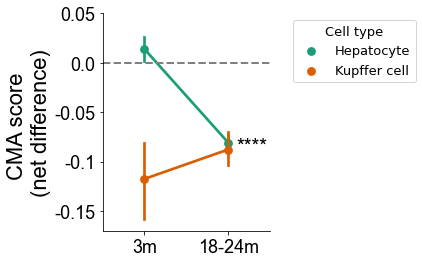

In [15]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode, hue='cell_type', order=["3m", "18-24m"], 
              hue_order=["hepatocyte", 'Kupffer cell'], palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["3m", "18-24m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.17, 0.05) 
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})

# Legend
celulas = ['Hepatocyte', 'Kupffer cell']
h, l = ax.get_legend_handles_labels()
ax.legend(h, celulas, bbox_to_anchor=(1.1, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

# Stats
x1= 1.1   
y1=-0.09
plt.text(x1, y1, "****", fontsize=20, **hfont)

plt.show()

## CMA net score/cell type & sex

### Stats

In [16]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode[barcode['cell_type']==i].reset_index()    
    
    # 2-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Hepatocyte 2-way Anova

                       df     sum_sq   mean_sq          F        PR(>F)
C(new_age)            1.0   2.345523  2.345523  41.580274  1.657600e-10
C(sex)                1.0   0.011850  0.011850   0.210077  6.467930e-01
C(new_age):C(sex)     1.0   0.048283  0.048283   0.855929  3.550732e-01
Residual           1158.0  65.322211  0.056410        NaN           NaN


Hepatocyte Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1         group2      stat   pval  pval_corr reject
-------------------------------------------------------------
18-24m & female 18-24m & male -0.9872 0.3239       1.0  False
18-24m & female   3m & female -3.1119 0.0021    0.0126   True
18-24m & female     3m & male -3.9826 0.0001    0.0005   True
  18-24m & male   3m & female -4.4323    0.0    0.0001   True
  18-24m & male     3m & male -5.2663    0.0       0.0   True
    3m & female     3m & male  0.2148   0.83       1.0 

### Graphs

#### Hepatocytes

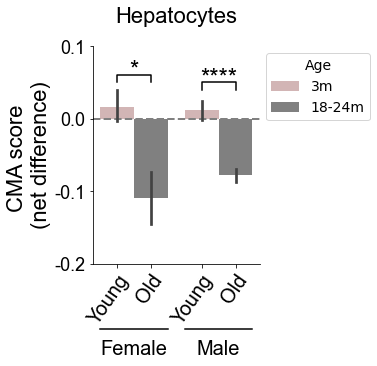

In [21]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type=='hepatocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.10)
ax.set_yticks([-0.20, -0.10, 0.00, 0.10])
ax.set_yticklabels([-0.20, -0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.05 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x3, x4 = 0.8, 1.2   
y2, h, col = 0.04 , 0.01, 'k'
plt.plot([x3, x3, x4, x4], [y2, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((x3+x4)*.5, y2, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('./Hepatocytes_nscorrect_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Kuppfer cells

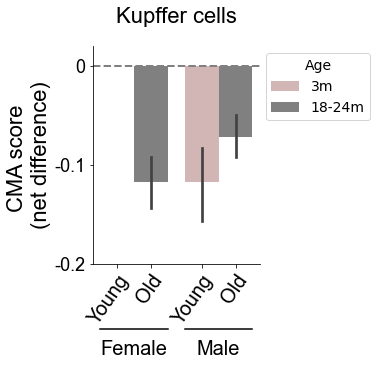

In [26]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type=='Kupffer cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.02)
ax.set_yticks([-0.20, -0.10, 0])
ax.set_yticklabels([-0.20, -0.10, 0], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('./Kupffer_nscorrect_sex.png',bbox_inches='tight', dpi=300)

plt.show()

## CMA network heatmaps by cell type & sex

In [28]:
# Load matrix reordered
model_matrix = pd.read_excel('../activation_model.xlsx', 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [31]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
      
        
    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,6))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis')
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

    plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

    plt.ylim(15.5, -0.5)

    plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                color='k', size=16, **hfont)
    ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                color='green', size=16, **hfont)
    ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                color='red', size=16, **hfont)
    ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13088\4128768129.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13088\4128768129.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13088\4128768129.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13088\4128768129.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] 

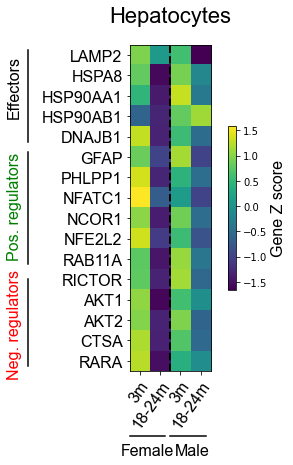

In [33]:
sex_heatmaps(cellpop='hepatocyte')

In [75]:
# There are no female 3m kuppfer cells so we adjust the previous function
def sex_kupp(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 3))
    
    #Find cell indices for each condition
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
      
        
    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,6))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis')
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

    plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

    plt.ylim(15.5, -0.5)

    plt.xticks(np.arange(3), ['18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=0.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-2, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                color='k', size=16, **hfont)
    ax.plot([-1.65,-1.65],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Pos. regulators', xy=(-2, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                color='green', size=16, **hfont)
    ax.plot([-1.65,-1.65],[4.75, 10.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Neg. regulators', xy=(-2, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                color='red', size=16, **hfont)
    ax.plot([-1.65,-1.65],[11, 15.25], color="k", transform=trans, clip_on=False)
    
    ax.annotate('Female', xy=(-0.5, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.25,0.5],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('Male', xy=(1.75, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1, 2.5],[-.2,-.2], color="k", transform=trans2, clip_on=False)
    
    plt.savefig('./Kpcells_sexheatmap.png',bbox_inches='tight', dpi=300)

    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13088\1006465331.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13088\1006465331.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13088\1006465331.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.41it/s]


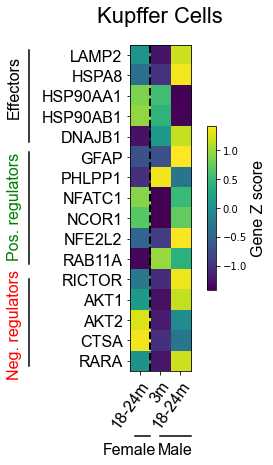

In [76]:
sex_kupp(cellpop='Kupffer cell')

## Ridge plots for L2 and L1

In [77]:
# Codes for L2 and L1
lys = ['ENSMUSG00000016534', 'ENSMUSG00000031447']

In [81]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, lys]
barcode_lys = adata.obs.copy()

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    
# Converting lys_zs.X to a pandas df
df_lys = pd.DataFrame(lys_zs.tolist())
df_lys.rename(columns={0:"L2", 1:'L1'}, inplace=True)

# Generating barcode df and appending L2 column
barcode_lys = barcode_lys.reset_index()
barcode_lys = pd.concat([barcode_lys, df_lys], axis=1)
barcode_lys = barcode_lys [['index', 'cell', 'cell_type', 'sex', 'age', 'L2', 'L1']]

barcode_lys.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 999.83it/s]


,index,cell,cell_type,sex,age,L2,L1
0,A10_B000767_B009945_S10.mm10-plus-4-0,A10_B000767,hepatocyte,female,18m,1.169564,-1.714298
1,A10_D045313_B009942_S10.mm10-plus-4-0,A10_D045313,hepatocyte,male,18m,0.841873,0.807435
2,A11_B000767_B009945_S11.mm10-plus-4-0,A11_B000767,myeloid leukocyte,female,18m,-1.301978,0.620381
3,A11_B001247_B009941_S11.mm10-plus-4-0,A11_B001247,endothelial cell of hepatic sinusoid,female,18m,-1.301978,0.722846
4,A11_B002688_B009944_S11.mm10-plus-4-0,A11_B002688,endothelial cell of hepatic sinusoid,male,18m,0.950798,0.655274


In [82]:
# Generating new ages
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'age'] == '3m':        
        barcode_lys.loc[j, 'new_age'] = '3m'

    elif barcode_lys.loc[j, 'age'] == '18m':                
        barcode_lys.loc[j, 'new_age'] = '18-24m'

    elif barcode_lys.loc[j, 'age'] == '24m': 
        barcode_lys.loc[j, 'new_age'] = '18-24m'
        
barcode_lys.head()

,index,cell,cell_type,sex,age,L2,L1,new_age
0,A10_B000767_B009945_S10.mm10-plus-4-0,A10_B000767,hepatocyte,female,18m,1.169564,-1.714298,18-24m
1,A10_D045313_B009942_S10.mm10-plus-4-0,A10_D045313,hepatocyte,male,18m,0.841873,0.807435,18-24m
2,A11_B000767_B009945_S11.mm10-plus-4-0,A11_B000767,myeloid leukocyte,female,18m,-1.301978,0.620381,18-24m
3,A11_B001247_B009941_S11.mm10-plus-4-0,A11_B001247,endothelial cell of hepatic sinusoid,female,18m,-1.301978,0.722846,18-24m
4,A11_B002688_B009944_S11.mm10-plus-4-0,A11_B002688,endothelial cell of hepatic sinusoid,male,18m,0.950798,0.655274,18-24m


In [83]:
# Reducing df only to cells of interest
barcode_lys = barcode_lys[(barcode_lys.cell_type==cells[0]) | (barcode_lys.cell_type==cells[1])].reset_index()

### Graphs

#### L2 female

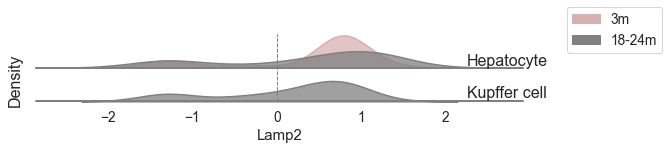

In [111]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.25)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.75, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=1.1, s="Hepatocyte", fontsize=16) 
plt.text(x=2.25, y=0.1, s="Kupffer cell", fontsize=16)  


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=16)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 3), facecolor='white')

plt.savefig('./Liver_L2_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

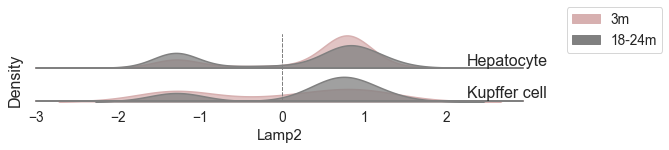

In [112]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.25)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.75, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=1.1, s="Hepatocyte", fontsize=16) 
plt.text(x=2.25, y=0.1, s="Kupffer cell", fontsize=16)  


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=16)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 3), facecolor='white')

plt.savefig('./Liver_L2_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

#### L1 female

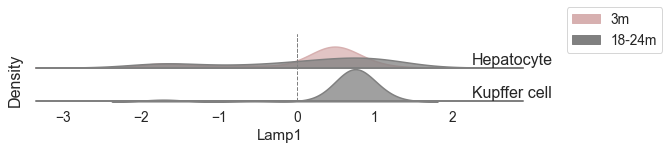

In [118]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.25)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.75, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=1.6, s="Hepatocyte", fontsize=16) 
plt.text(x=2.25, y=0.15, s="Kupffer cell", fontsize=16)  


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=16)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 3), facecolor='white')

plt.savefig('./Liver_L1_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

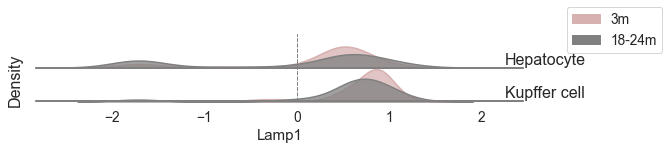

In [122]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.25)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['3m', '18-24m'], aspect=7, height=1.1, palette=['#D7B0B0', '#808080'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.75, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=1.95, s="Hepatocyte", fontsize=16) 
plt.text(x=2.25, y=0.2, s="Kupffer cell", fontsize=16)  


# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=16)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#D7B0B0', edgecolor='#D7B0B0', label='3m'),
                   Patch(facecolor='#808080', edgecolor='#808080', label='18-24m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.3, 3), facecolor='white')

plt.savefig('./Liver_L1_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()